# New York Taxi Analysis

Data can be found here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (January 2019 Dataset)

In this project, we are trying to predict the average income of a taxi driver in New York City, per hour and per region as it is divided in the dataset.

<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

## 0. Import Libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline

%load_ext autoreload
%autoreload 2

## 1. Import Data <a id='imports_data'></a>
[Back to top](#table_of_contents)

In [2]:
# Load the data 
taxi_df = pd.read_csv('data/yellow_tripdata_2019-01.csv')

In [17]:
# Examine the first 5 entries 
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [4]:
# The data has 7,667,792 rows and 18 columns 
taxi_df.shape

(7667792, 18)

## 2. Data Exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

**First**, drop irrelevant / unhelpful columns
Metadata can be found here: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

*Columns to drop:* 
- VendorID: A code indicating the TPEP provider that provided the record.
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.
- payment_type: A numeric code signifying how the passenger paid for the trip (can be good to keep if there are problems with the data). 
- tip_amount: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
- fare_amount, etra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge: we only care about the total_amount

In [18]:
taxi_data = taxi_df[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                       'passenger_count', 'trip_distance', 'RatecodeID', 
                       'PULocationID', 'DOLocationID', 'payment_type',
                       'total_amount']]

In [21]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E935A35C8>,
      dtype=object)

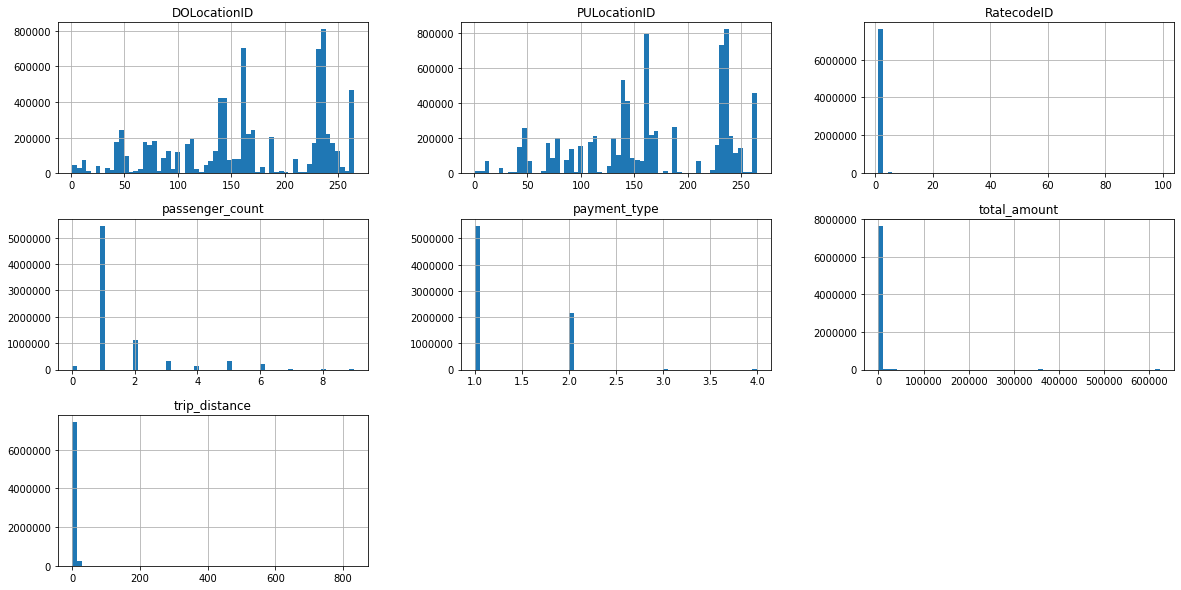

In [22]:
taxi_data.hist(figsize=(20,10), bins=60)

In [23]:
taxi_data['RatecodeID'].value_counts()

1     7430139
2      166090
5       54569
3       11801
4        4895
99        252
6          46
Name: RatecodeID, dtype: int64

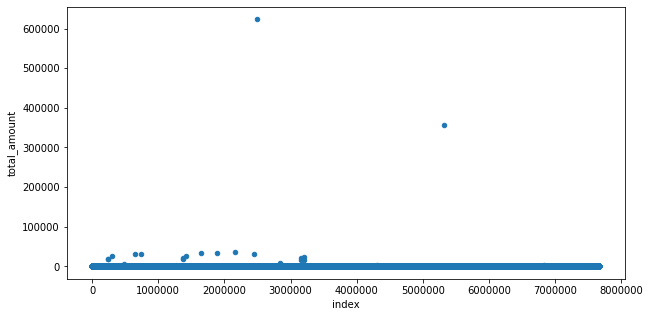

In [24]:
# Observation: There are clearly outliers 

taxi_data.reset_index().plot(kind='scatter', y='total_amount', 
                             x='index', figsize=(10,5))

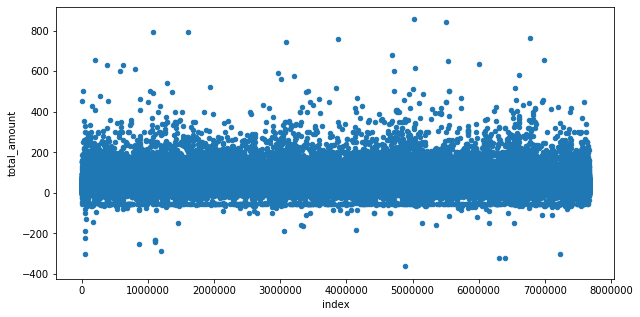

In [25]:
# Observation: A lot of data lies below 1000
# But, we have some negative values to deal with 

taxi_data[taxi_data['total_amount']<1000].reset_index().plot(
    kind='scatter', y='total_amount', x='index', figsize=(10,5))

We have two things to deal with: 
(1) Negative values 
(2) Very high values 

##### Negative Values and Zero Values

Only a very small amount of data (1 in 1000) with negative values of total amount. 
Most of these have payment type of 3 (no charge) or 4 (dispute).
Negative values are probably not going to help the model, so we are going to delete them. 

There are even a smaller amount of data (1 in 7000) with zero total amount. 
Most of these data have zero trip distance. 
Zero values are probably not going to help the model, so we are going to delete them. 

(7131, 9)


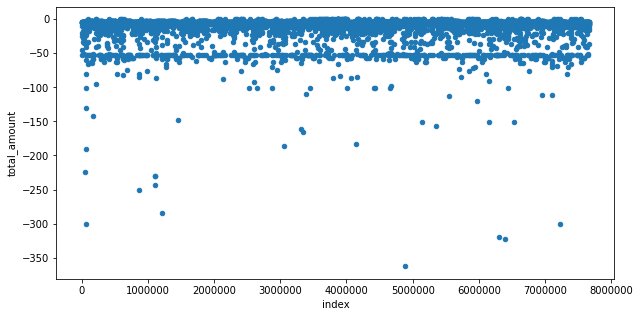

In [26]:
# There are about 7000 negative entries, and more than 7,000,000 entries in total
# We can delete these negative entries without losing too much data

print(taxi_data[taxi_data['total_amount'] < 0].shape)
taxi_data[taxi_data['total_amount'] < 0].reset_index().plot(
    kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [27]:
taxi_data[taxi_data['total_amount'] < 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
663,2019-01-01 00:32:56,2019-01-01 00:33:35,2,0.10,1,148,148,3,-3.8
2402,2019-01-01 00:14:18,2019-01-01 00:40:55,1,4.13,1,170,238,4,-20.3
2541,2019-01-01 00:31:27,2019-01-01 00:42:39,1,1.35,1,162,234,4,-9.8
2544,2019-01-01 00:45:57,2019-01-01 00:46:07,1,0.00,1,234,234,4,-3.8
2547,2019-01-01 00:48:35,2019-01-01 00:49:59,1,0.16,1,234,234,4,-4.3


In [28]:
# Most of negative data has payment_types of 3 (no charge) or 4 (dispute)

taxi_data[taxi_data['total_amount'] < 0]['payment_type'].value_counts()

3    4088
4    2666
2     376
1       1
Name: payment_type, dtype: int64

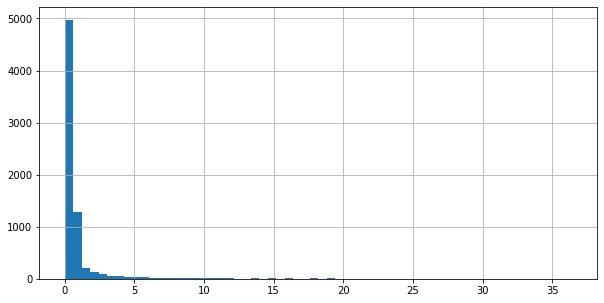

In [29]:
# Most of these have very short trip distance anyway
taxi_data[taxi_data['total_amount'] < 0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [32]:
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(1414, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
3552,2019-01-01 00:18:46,2019-01-01 00:18:46,1,0.0,5,186,264,2,0.0
9138,2019-01-01 00:41:47,2019-01-01 00:41:47,1,0.0,5,246,264,2,0.0
13256,2019-01-01 00:19:38,2019-01-01 00:20:35,1,0.0,1,193,193,1,0.0
13257,2019-01-01 00:43:34,2019-01-01 00:43:34,1,0.0,1,7,7,2,0.0
13258,2019-01-01 00:02:52,2019-01-01 00:02:52,1,0.0,1,264,7,2,0.0


In [34]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

1    815
2    569
3     29
4      1
Name: payment_type, dtype: int64

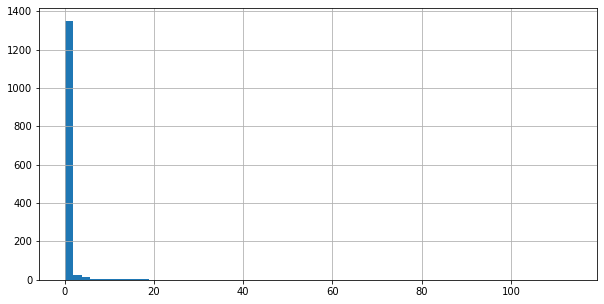

In [35]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [36]:
# Most of 0 entries have 0 trip distance, which makes sense
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

0.00    1270
1.00       4
0.01       4
0.02       4
0.03       3
        ... 
0.59       1
0.18       1
5.70       1
0.87       1
1.04       1
Name: trip_distance, Length: 110, dtype: int64

##### Very High Values

We agree to cut from $200 level.

In [41]:
# We are looking for a safe cut-off point
# Remember, we have more than 7,000,000 data points 

print('No. of data with total amount above 500:', taxi_data[taxi_data['total_amount']>500].shape)
print('No. of data with total amount above 300:', taxi_data[taxi_data['total_amount']>300].shape)
print('No. of data with total amount above 200:', taxi_data[taxi_data['total_amount']>200].shape)
print('No. of data with total amount above 100:', taxi_data[taxi_data['total_amount']>100].shape)

No. of data with total amount above 500: (56, 9)
No. of data with total amount above 300: (307, 9)
No. of data with total amount above 200: (1166, 9)
No. of data with total amount above 100: (10832, 9)


In [43]:
# Mean total amount is $15.68

taxi_data['total_amount'].describe()

count    7.667792e+06
mean     1.568222e+01
std      2.622932e+02
min     -3.628000e+02
25%      8.190000e+00
50%      1.127000e+01
75%      1.656000e+01
max      6.232617e+05
Name: total_amount, dtype: float64

## 3. Data Cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [49]:
taxi_data.shape

(7667792, 9)

In [58]:
taxi_data_filtered = taxi_data[(taxi_data['total_amount']>0) & 
                                (taxi_data['total_amount']<200)]
taxi_data_filtered.shape

(7658076, 9)

Check for missing values 

In [59]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

## 4. Data Preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

Data preparation is the process of cleaning and transforming raw data prior to processing and analysis. It is an important step prior to processing and often involves reformatting data, making corrections to data and the combining of data sets to enrich data.

In [66]:
taxi_data_prepared = taxi_data_filtered.copy()

Make sure everyhing is the right type

In [67]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

Cast tpep_pickup_datetime and tpep_dropoff_datetime to datetime type

In [69]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [71]:
taxi_data_prepared.loc[:, 'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:, 'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:, 'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:, 'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [73]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

Transforming variables into the formats we need them 

In [79]:
taxi_data_prepared['transaction_date']=taxi_data_prepared.tpep_pickup_datetime.dt.date
taxi_data_prepared['transaction_year']=taxi_data_prepared.tpep_pickup_datetime.dt.year
taxi_data_prepared['transaction_month']=taxi_data_prepared.tpep_pickup_datetime.dt.month
taxi_data_prepared['transaction_day']=taxi_data_prepared.tpep_pickup_datetime.dt.day
taxi_data_prepared['transaction_hour']=taxi_data_prepared.tpep_pickup_datetime.dt.hour

In [80]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,236,236,1,5.80,2018-12-21,2018,12,21,13
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,193,193,2,7.55,2018-11-28,2018,11,28,15
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,193,193,2,55.55,2018-11-28,2018,11,28,15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013EA5B5FF48>,
      dtype=object)

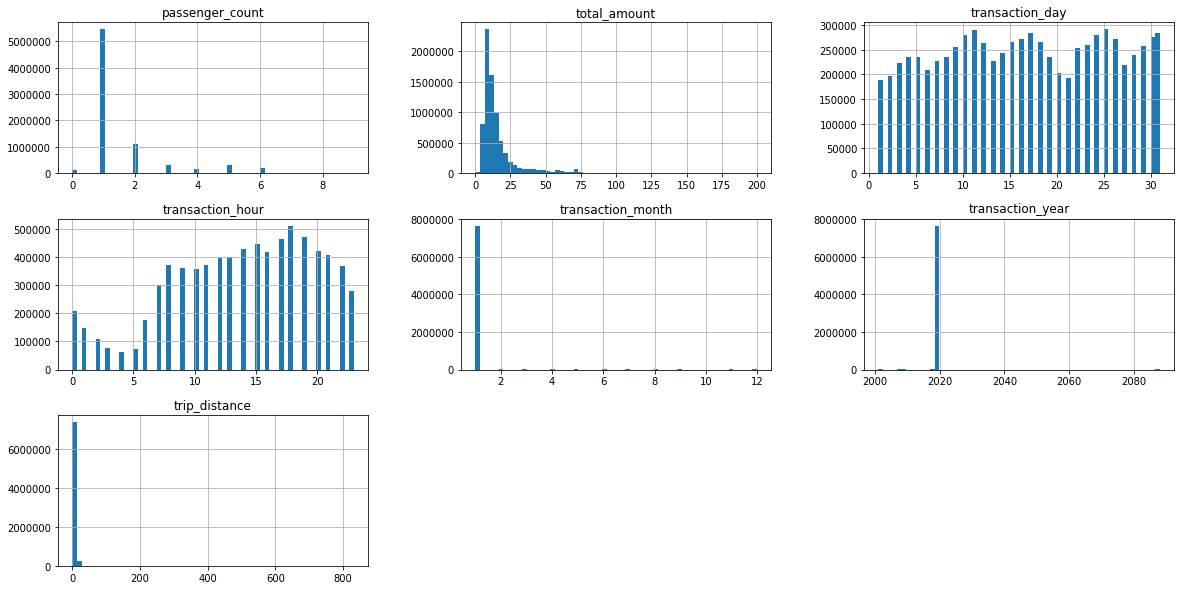

In [81]:
taxi_data_prepared.hist(bins=60, figsize=(20,10))

The data seems to contain data from time that are not in January 2019. This is not expected given the dataset we downloaded. We should drop these entries. 

In [84]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared.transaction_year == 2019]
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared.transaction_month == 1]

Noting down categorical and numerical columns 

In [86]:
categorical_columns = ['PULocationID', 'transaction_date', 'transaction_month', 'transaction_day', 'transaction_hour']
numerical_columns = ['trip_distance', 'total_amount']
all_needed_columns = categorical_columns + numerical_columns

In [87]:
# Leaving only the data that we need (the rest were only useful for data preparation)

main_taxi_df = taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(7657544, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,151,2019-01-01,1,1,0,1.5,9.95
1,239,2019-01-01,1,1,0,2.6,16.30
7,163,2019-01-01,1,1,0,1.3,9.05
8,229,2019-01-01,1,1,0,3.7,18.50
9,141,2019-01-01,1,1,0,2.1,13.00


Aggregate data points 

Now is a good time to think about what we want to predict. Depending on this, we need to transform our data to have a certain format.

In [89]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(102521, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2019-01-01,1,1,2,0.0,21.800,1
1,1,2019-01-01,1,1,5,0.0,87.300,1
2,1,2019-01-01,1,1,6,0.0,80.300,1
3,1,2019-01-01,1,1,8,0.0,128.580,2
4,1,2019-01-01,1,1,10,16.9,43.245,4


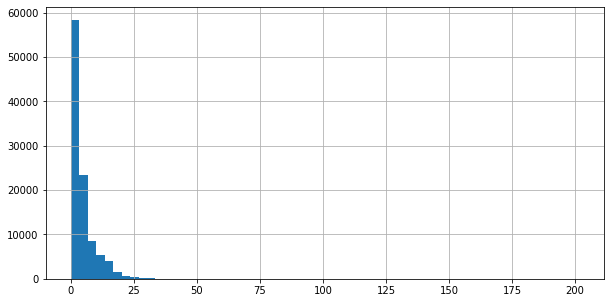

In [95]:
taxi_grouped_by_region.trip_distance.hist(bins=60, figsize=(10,5))

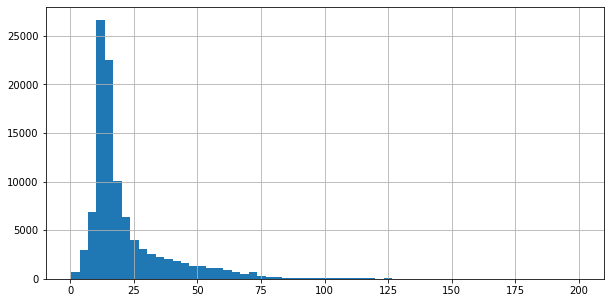

In [96]:
taxi_grouped_by_region.total_amount.hist(bins=60, figsize=(10,5))